# Outlier detection in the CMS claims data set with HDBSCAN #
Here, we will explore the step-by-step process of outlier detection in the CMS claims data set, including an exploration of how the clustering algorithm is actually treating this data under the hood.  We'll start by importing some things we need (including tools like our PandasDBReader, which I've coded elsewhere).

In [1]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from database_tools import PandasDBReader
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

Next, we define a state, a specialty, and a configuration file which tells the Reader which columns to read from the database.

In [2]:
yaml_config = "./config.yaml"
state = "WY"
specialty = "Psychiatry"
db_reader = PandasDBReader(yaml_config, [state], [specialty])

In [19]:
print(len(db_reader.d_f["npi"].values))

394


The first thing to is look at the range of the data, which I will accomplish here with a box plot.

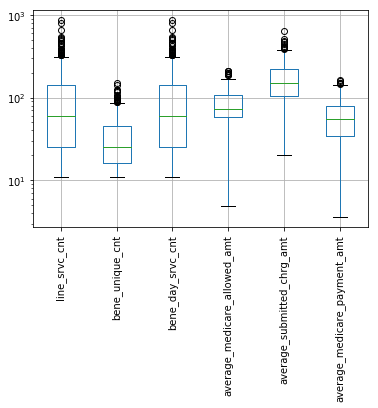

In [3]:
df = db_reader.d_f  # For simplicity, get a shorter name for the DataFrame inside the DBReader.
df.boxplot()
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()

Considering the presence of a substantial number of outliers in the data, I'll use a scaler to pre-process the data prior to clustering. This is necessary for the data ranges to be similar - otherwise, differences in the magnitude of point-to-point distances in the clustering algorithm will cause certain variables to overwhelm smaller ones. For example, the distance between the top two points in the `line_srvc_count` column is ~10,000, greater than the entire data range of the `bene_unique_cnt` column. 

In [4]:
# Extracting the numbers:
num_df = df[[
    'line_srvc_cnt',
    'bene_unique_cnt',
    'bene_day_srvc_cnt',
    'average_medicare_allowed_amt',
    'average_submitted_chrg_amt',
    'average_medicare_payment_amt',
]]
# Now we scale the data using a RobustScaler.
num_df_scaled = StandardScaler().fit_transform(num_df)

The data should be ready for clustering, so we'll declare a HDBSCAN object and then fit the data with it.

In [5]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
clusterer.fit(num_df_scaled)
print(clusterer.labels_.max())

1


HDBSCAN starts by generating the mininmum spanning tree of the data set.  Borrowing from graph theory, the minimum spanning tree finds the edges (think of an edge as a line connecting two points) which connect all of the data points in the data set while simultaneously minimizing the edge weight. The edge weight, in the simplest case, is simply the Euclidean distance between the points (in which case the edges of the minimum spanning tree are constructed basically to have the shortest total distance when their lengths are summed up). However, in HDBSCAN, a "mutual reachability distance" is used to define edge weights instead - in brief, this is a distance metric that accounts for density.

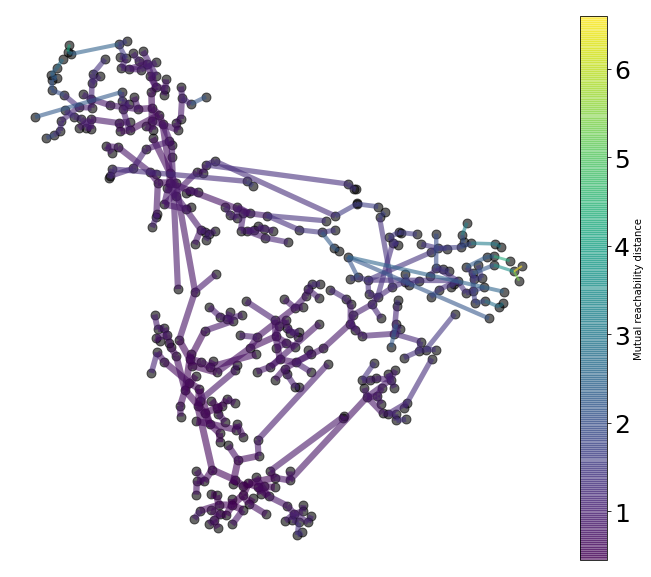

In [50]:
plt.gcf().clear()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=10, which='both')
plt.rc('ytick', labelsize=25)
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
plt.show()

With ~4000 data points (among the smaller datasets considered by FraudHacker!), the minimum spanning tree is rather complicated and difficult to understand on an intuitive level, but this at least gives a graphical flavor of the first step in the clustering process. For the interested reader, there are many simpler examples online. The next step in the HDBSCAN algorithm is to sort the edges by distance (mutual reachability distance) and go down the list, creating a new cluster from the points connected by the edge. This process continues as larger and larger distances are merged, and a hierarchical single linkage tree is generated.  It turns out that the single linkage tree of this data set is too large for Python's hard-coded recursion limit (the visualization method in HDBSCAN is implemented recursively).

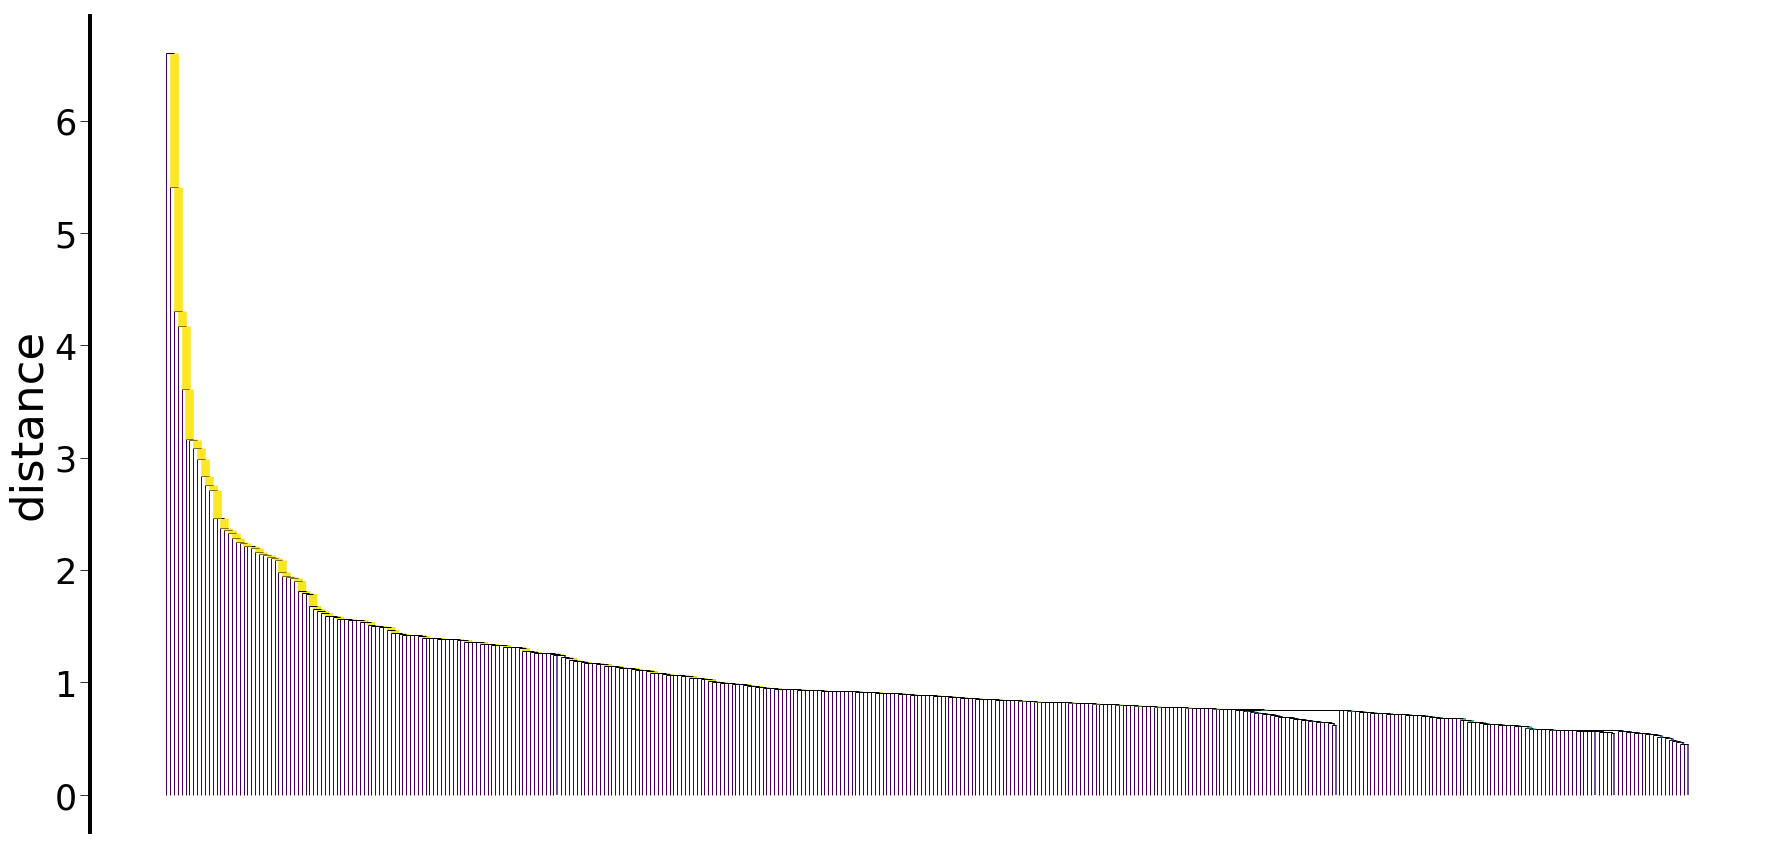

In [38]:
plt.gcf().clear()
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.yaxis.set_tick_params(length=10, which='both')
plt.rc('ytick', labelsize=35)
plt.ylabel("Distance", fontsize=45)
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=False)
plt.show()

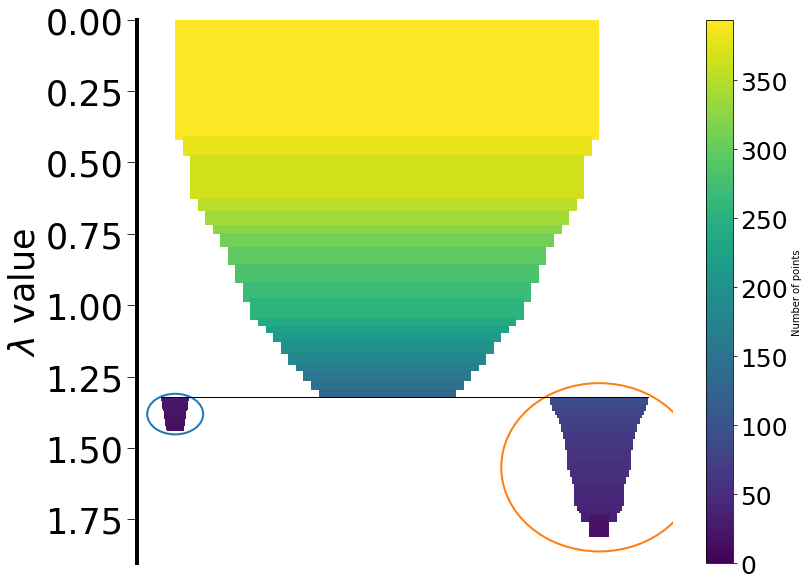

In [41]:
plt.gcf().clear()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.yaxis.set_tick_params(length=10, which='both')
plt.rc('ytick', labelsize=25)
plt.ylabel("Distance", fontsize=35)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

As we can see, none of the other nodes on the tree persist with enough members as the density threshold is increased to be selected as actual clusters. Thus, there is only one cluster in the data set - not necessarily surprising for a small specialty (Thoracic Surgery) in a single state (FL).  While doing HDBSCAN, we get an outlier score for free based on a Global Local Outlier Score from Hierarchies (GLOSH) which describes the difference between when a point gets kicked out of a cluster and when that cluster disappears entirely as the density threshold increases. Basically, a non-outlier will get kicked out a cluster at a similar density to the density at which the host cluster disappears; an outlier will get kicked out well beforehand.  We can visualize the distribution of outlier scores on these points.

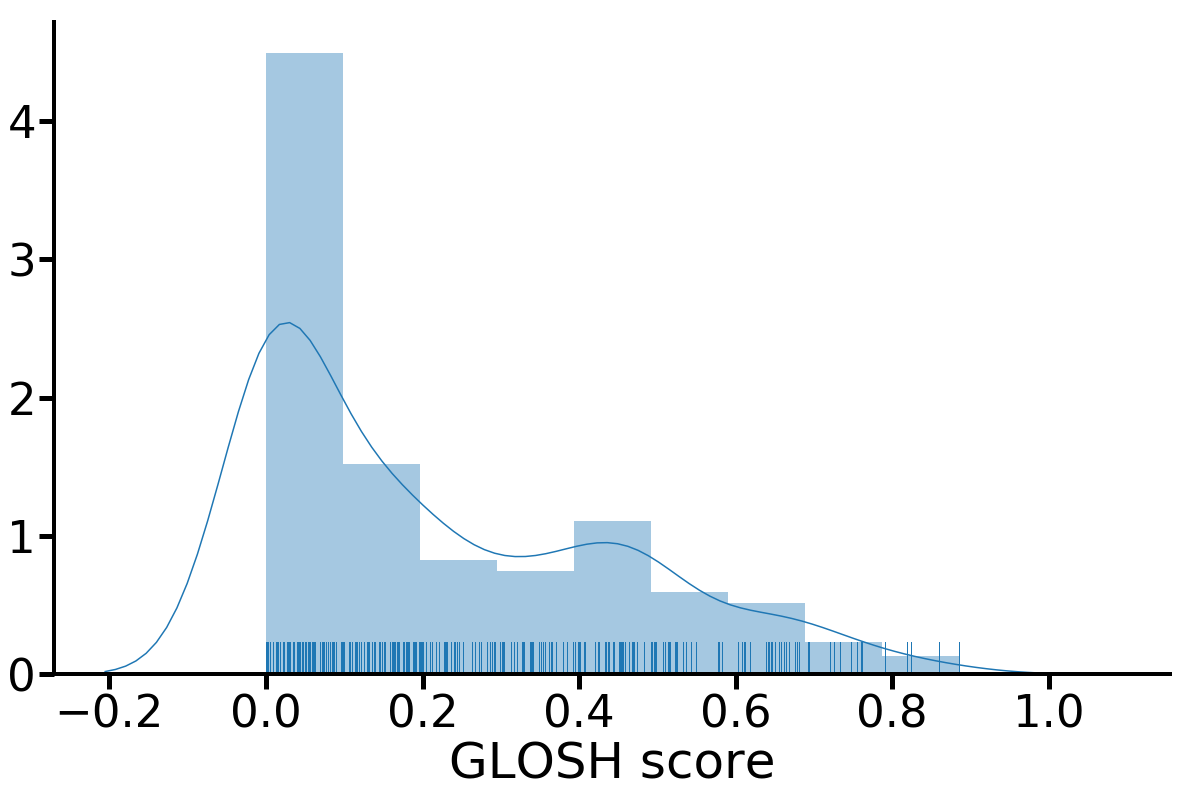

In [6]:
plt.gcf().clear()
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.gca().tick_params(width=5, length=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
plt.xlabel("GLOSH score", fontsize=50)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
plt.show()

We can define outliers as anything having a GLOSH score above a particular threshold.

In [42]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

In [43]:
# Visualizing the outliers will be easier with a 2D projection.
projection = TSNE(perplexity=30).fit_transform(num_df_scaled)

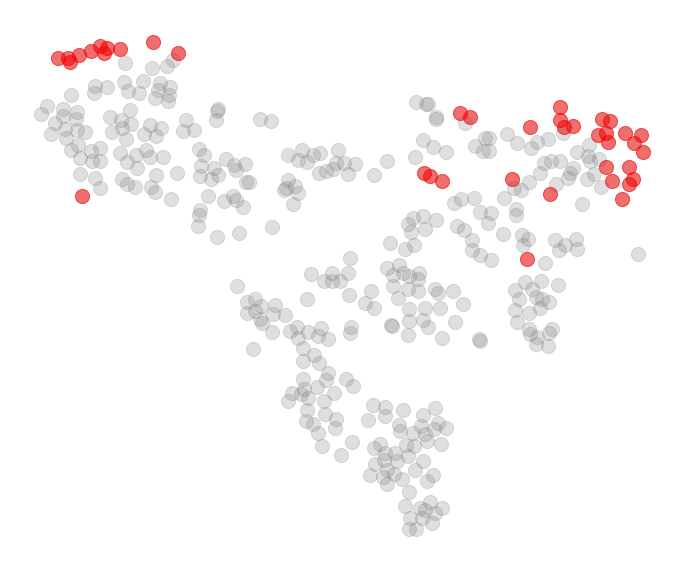

In [61]:
plt.gcf().clear()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.scatter(projection.T[0], projection.T[1], c='grey', s=200, alpha=0.25)
ax.scatter(projection.T[0][outliers], projection.T[1][outliers], c='red', s=200, alpha=0.5)
plt.show()

In [108]:
# Just as a sanity check, let's visualize the cluster colors.

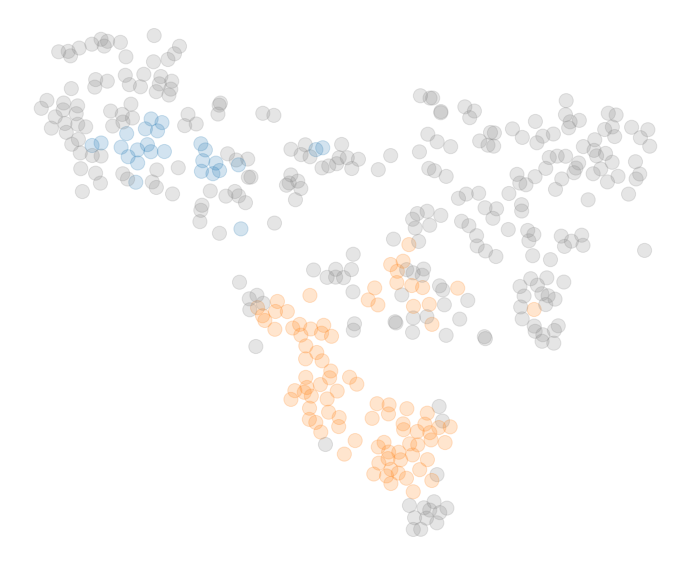

In [59]:
plt.gcf().clear()
palette = sns.color_palette()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
plt.xticks([])
plt.yticks([])plt.gcf().clear()

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
ax.scatter(projection.T[0], projection.T[1], c=cluster_colors, alpha=0.2, s=200)
plt.show()